# Mixed States Reconstruction (Infidelity as loss)

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [2]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation (Haar Distribution)

In [3]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [5]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [6]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand()**(1/3)* bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [7]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [8]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [9]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [10]:
#define loss function
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)


   numer = tf.math.abs(tf.linalg.trace(tf.matmul(rho_a, rho_b)))
   den = tf.math.sqrt(tf.linalg.trace(tf.linalg.matmul(rho_a, rho_a)) * tf.linalg.trace(tf.linalg.matmul(rho_b, rho_b)))
   numer = tf.cast(numer, tf.complex64)
   infidelity = 1 - numer/den
   return infidelity

In [11]:
print(tf.math.abs(tf.linalg.trace(tf.matmul(Y_tf, Y_tf))))
print(tf.linalg.matmul(Y_tf, Y_tf))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]], shape=(2, 2), dtype=complex64)


In [12]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [13]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [14]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [15]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [16]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [17]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [18]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [19]:
#GENERATE DATA
data = generate_Haar_data(1, 100)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [20]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [21]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [22]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [23]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [28]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[60:80], bloch_vectors_with_noise[80:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[60:80], bloch_vectors_noise_free[80:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [29]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [30]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a *b
  return output

In [41]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(64, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x) 
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal) #normal


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 64)           256         ['input_7[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 64)           4160        ['dense_6[0][0]']                
                                                                                                  
 vector (Dense)                 (None, 3)            195         ['dense_7[0][0]']                
                                                                                            

In [42]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=inf)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=5, epochs=200)

Epoch 1/200
6/6 [==============================] - 2s 68ms/step - loss: 0.2733 - val_loss: 0.1608
Epoch 2/200
6/6 [==============================] - 0s 19ms/step - loss: 0.2094 - val_loss: 0.1272
Epoch 3/200
6/6 [==============================] - 0s 16ms/step - loss: 0.1453 - val_loss: 0.1052
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0929 - val_loss: 0.0870
Epoch 5/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0595 - val_loss: 0.0629
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0299 - val_loss: 0.0347
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0176 - val_loss: 0.0189
Epoch 8/200
6/6 [==============================] - 0s 23ms/step - loss: 0.0095 - val_loss: 0.0109
Epoch 9/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 0.0070
Epoch 10/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 11/200
6/6 [=

6/6 [==============================] - 0s 19ms/step - loss: 4.7386e-06 - val_loss: 0.0020
Epoch 82/200
6/6 [==============================] - 0s 18ms/step - loss: 4.7207e-06 - val_loss: 0.0019
Epoch 83/200
6/6 [==============================] - 0s 20ms/step - loss: 4.3869e-06 - val_loss: 0.0019
Epoch 84/200
6/6 [==============================] - 0s 18ms/step - loss: 4.2319e-06 - val_loss: 0.0019
Epoch 85/200
6/6 [==============================] - 0s 18ms/step - loss: 3.9657e-06 - val_loss: 0.0019
Epoch 86/200
6/6 [==============================] - 0s 19ms/step - loss: 3.7889e-06 - val_loss: 0.0019
Epoch 87/200
6/6 [==============================] - 0s 18ms/step - loss: 3.4928e-06 - val_loss: 0.0019
Epoch 88/200
6/6 [==============================] - 0s 18ms/step - loss: 3.5008e-06 - val_loss: 0.0019
Epoch 89/200
6/6 [==============================] - 0s 18ms/step - loss: 3.4730e-06 - val_loss: 0.0019
Epoch 90/200
6/6 [==============================] - 0s 19ms/step - loss: 3.2743e-06 - 

6/6 [==============================] - 0s 18ms/step - loss: 6.7751e-07 - val_loss: 0.0019
Epoch 161/200
6/6 [==============================] - 0s 19ms/step - loss: 1.2398e-06 - val_loss: 0.0019
Epoch 162/200
6/6 [==============================] - 0s 18ms/step - loss: 8.4043e-07 - val_loss: 0.0019
Epoch 163/200
6/6 [==============================] - 0s 18ms/step - loss: 9.1394e-07 - val_loss: 0.0019
Epoch 164/200
6/6 [==============================] - 0s 21ms/step - loss: 1.1226e-06 - val_loss: 0.0019
Epoch 165/200
6/6 [==============================] - 0s 21ms/step - loss: 9.0202e-07 - val_loss: 0.0019
Epoch 166/200
6/6 [==============================] - 0s 18ms/step - loss: 6.4174e-07 - val_loss: 0.0019
Epoch 167/200
6/6 [==============================] - 0s 18ms/step - loss: 5.9406e-07 - val_loss: 0.0019
Epoch 168/200
6/6 [==============================] - 0s 18ms/step - loss: 6.9936e-07 - val_loss: 0.0019
Epoch 169/200
6/6 [==============================] - 0s 18ms/step - loss: 6.25

In [43]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

1/1 - 0s - loss: 0.0015 - 396ms/epoch - 396ms/step


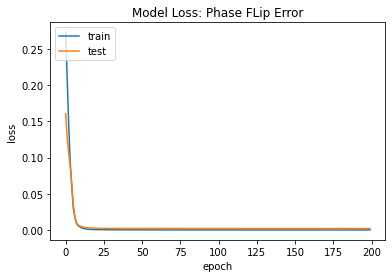

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9987646415105361-5.418103148496407e-09j), shape=(), dtype=complex128)


(0.9994883113554278+2.8869271302453045e-08j)
tf.Tensor([-0.3250917 +0.j -0.4096395 +0.j  0.30392972+0.j], shape=(3,), dtype=complex64)
tf.Tensor([-0.3495915 +0.j -0.41554236+0.j  0.26640716+0.j], shape=(3,), dtype=complex64)


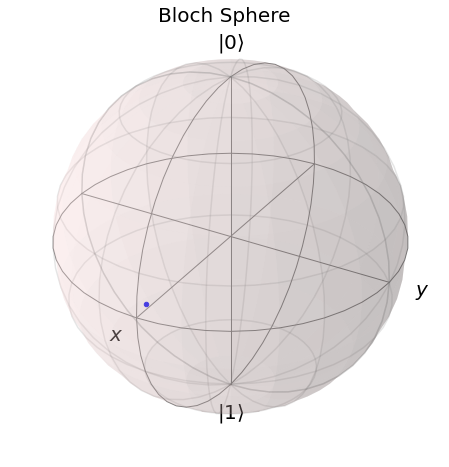

In [46]:
den_mat = rho_from_vec(y_prediction[0])
den_mat = np.asarray(den_mat)

den_mat_id = rho_from_vec(y_test[0])
den_mat_id = np.asarray(den_mat_id)

print(fidelity_function(den_mat_id, den_mat))


print(y_prediction[0])
print(y_test[0])

Bloch_sphere(y_prediction[1:2])

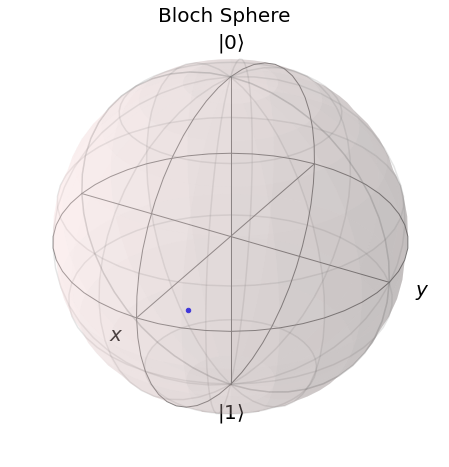

In [47]:
Bloch_sphere(x_test[1:2])

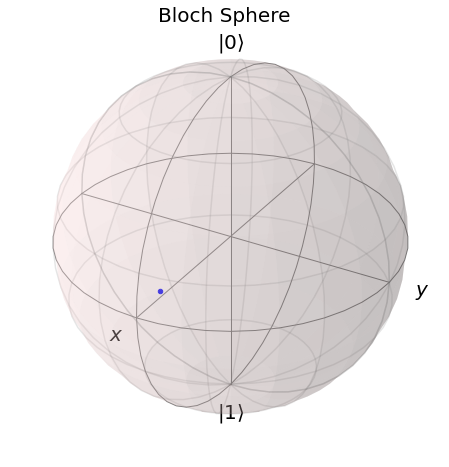

In [48]:
Bloch_sphere(y_test[1:2])

## Test with Alternative Fidelity

In [36]:
@tf.function
def inf_vec(a,b):
    fid = 0.5 * (1 + tf.tensordot(a, b, 1) + ((1 - tf.tensordot(a, a, 1))*(1 - tf.tensordot(b, b, 1)))**(1/2))
    return 1 - fid

In [39]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(3,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3),
  #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  ])

In [40]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=inf)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 1s 85ms/step - loss: 0.2420 - val_loss: 0.2325
Epoch 2/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.2199 - val_loss: 0.2124
Epoch 3/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.1990 - val_loss: 0.1939
Epoch 4/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.1807 - val_loss: 0.1770
Epoch 5/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.1624 - val_loss: 0.1619
Epoch 6/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.1468 - val_loss: 0.1479
Epoch 7/1000
5/5 [==============================] - 0s 28ms/step - loss: 0.1332 - val_loss: 0.1349
Epoch 8/1000
5/5 [==============================] - 0s 34ms/step - loss: 0.1202 - val_loss: 0.1230
Epoch 9/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.1081 - val_loss: 0.1124
Epoch 10/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0978 - val_loss: 0.1025
Epoch 11/

Epoch 82/1000
5/5 [==============================] - 0s 32ms/step - loss: 5.5637e-04 - val_loss: 0.0011
Epoch 83/1000
5/5 [==============================] - 0s 27ms/step - loss: 5.4895e-04 - val_loss: 0.0011
Epoch 84/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.4095e-04 - val_loss: 0.0011
Epoch 85/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.3292e-04 - val_loss: 0.0011
Epoch 86/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.2711e-04 - val_loss: 0.0011
Epoch 87/1000
5/5 [==============================] - 0s 39ms/step - loss: 5.2069e-04 - val_loss: 0.0010
Epoch 88/1000
5/5 [==============================] - 0s 40ms/step - loss: 5.1335e-04 - val_loss: 0.0010
Epoch 89/1000
5/5 [==============================] - 0s 26ms/step - loss: 5.0664e-04 - val_loss: 0.0010
Epoch 90/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.9953e-04 - val_loss: 0.0010
Epoch 91/1000
5/5 [==============================] - 0s 28ms/ste

Epoch 158/1000
5/5 [==============================] - 0s 29ms/step - loss: 2.6449e-04 - val_loss: 7.5528e-04
Epoch 159/1000
5/5 [==============================] - 0s 27ms/step - loss: 2.6255e-04 - val_loss: 7.5008e-04
Epoch 160/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.6155e-04 - val_loss: 7.4655e-04
Epoch 161/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.5918e-04 - val_loss: 7.4635e-04
Epoch 162/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.5767e-04 - val_loss: 7.4209e-04
Epoch 163/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.5622e-04 - val_loss: 7.3993e-04
Epoch 164/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.5395e-04 - val_loss: 7.4165e-04
Epoch 165/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.5217e-04 - val_loss: 7.3736e-04
Epoch 166/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.5022e-04 - val_loss: 7.3709e-04
Epoch 167/1000
5/5 

5/5 [==============================] - 0s 28ms/step - loss: 1.2148e-04 - val_loss: 5.5041e-04
Epoch 309/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.2139e-04 - val_loss: 5.4844e-04
Epoch 310/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2059e-04 - val_loss: 5.4653e-04
Epoch 311/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.2053e-04 - val_loss: 5.4818e-04
Epoch 312/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.2104e-04 - val_loss: 5.3889e-04
Epoch 313/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.1908e-04 - val_loss: 5.4437e-04
Epoch 314/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1936e-04 - val_loss: 5.4562e-04
Epoch 315/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.1897e-04 - val_loss: 5.4616e-04
Epoch 316/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1748e-04 - val_loss: 5.4213e-04
Epoch 317/1000
5/5 [==============

5/5 [==============================] - 0s 28ms/step - loss: 6.0420e-05 - val_loss: 4.5019e-04
Epoch 459/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.1045e-05 - val_loss: 4.5414e-04
Epoch 460/1000
5/5 [==============================] - 0s 32ms/step - loss: 6.0669e-05 - val_loss: 4.5543e-04
Epoch 461/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.9596e-05 - val_loss: 4.4689e-04
Epoch 462/1000
5/5 [==============================] - 0s 29ms/step - loss: 6.1044e-05 - val_loss: 4.4610e-04
Epoch 463/1000
5/5 [==============================] - 0s 31ms/step - loss: 6.1587e-05 - val_loss: 4.5206e-04
Epoch 464/1000
5/5 [==============================] - 0s 33ms/step - loss: 5.9223e-05 - val_loss: 4.5310e-04
Epoch 465/1000
5/5 [==============================] - 0s 30ms/step - loss: 5.9152e-05 - val_loss: 4.4670e-04
Epoch 466/1000
5/5 [==============================] - 0s 28ms/step - loss: 5.8769e-05 - val_loss: 4.4662e-04
Epoch 467/1000
5/5 [==============

5/5 [==============================] - 0s 32ms/step - loss: 3.3995e-05 - val_loss: 4.0737e-04
Epoch 609/1000
5/5 [==============================] - 0s 34ms/step - loss: 3.4789e-05 - val_loss: 4.0990e-04
Epoch 610/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.3896e-05 - val_loss: 4.0384e-04
Epoch 611/1000
5/5 [==============================] - 0s 28ms/step - loss: 3.3613e-05 - val_loss: 3.9877e-04
Epoch 612/1000
5/5 [==============================] - 0s 28ms/step - loss: 3.3925e-05 - val_loss: 3.9920e-04
Epoch 613/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.4143e-05 - val_loss: 4.0904e-04
Epoch 614/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.3828e-05 - val_loss: 4.0417e-04
Epoch 615/1000
5/5 [==============================] - 0s 35ms/step - loss: 3.4878e-05 - val_loss: 4.0579e-04
Epoch 616/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.2705e-05 - val_loss: 3.9959e-04
Epoch 617/1000
5/5 [==============

5/5 [==============================] - 0s 30ms/step - loss: 1.9865e-05 - val_loss: 3.6985e-04
Epoch 759/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.9153e-05 - val_loss: 3.5797e-04
Epoch 760/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.9752e-05 - val_loss: 3.5975e-04
Epoch 761/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.8079e-05 - val_loss: 3.6585e-04
Epoch 762/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.9100e-05 - val_loss: 3.5755e-04
Epoch 763/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.9385e-05 - val_loss: 3.5201e-04
Epoch 764/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.9162e-05 - val_loss: 3.5842e-04
Epoch 765/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.8724e-05 - val_loss: 3.6362e-04
Epoch 766/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.8376e-05 - val_loss: 3.4990e-04
Epoch 767/1000
5/5 [==============

5/5 [==============================] - 0s 34ms/step - loss: 1.1934e-05 - val_loss: 3.2890e-04
Epoch 909/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.2206e-05 - val_loss: 3.1564e-04
Epoch 910/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.1950e-05 - val_loss: 3.2377e-04
Epoch 911/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.1935e-05 - val_loss: 3.2193e-04
Epoch 912/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.0906e-05 - val_loss: 3.2576e-04
Epoch 913/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1567e-05 - val_loss: 3.1938e-04
Epoch 914/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.2398e-05 - val_loss: 3.2309e-04
Epoch 915/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1755e-05 - val_loss: 3.2155e-04
Epoch 916/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.1747e-05 - val_loss: 3.2375e-04
Epoch 917/1000
5/5 [==============

In [41]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9982434077508074-2.204386870400859e-09j), shape=(), dtype=complex128)
